# Implementación de Transformers para Procesamiento de Lenguaje Natural (NLP)


### Objetivo
En esta evaluación, implementaremos un modelo basado en arquitecturas de Transformers para una tarea de procesamiento de lenguaje natural (NLP), utilizando el dataset **DailyDialog**. Este conjunto de datos de diálogos permite que el modelo practique en generación de texto y comprensión de contexto en interacciones cotidianas.

Usaremos TensorFlow para construir un modelo transformer básico con las siguientes características:
- **Encoder-Decoder**: para procesar la entrada y generar salida secuencial.
- **Atención Multi-cabezal**: para capturar dependencias a largo plazo en el diálogo.

Al final, evaluaremos el modelo utilizando métricas específicas de NLP, como BLEU o ROUGE.


## 1. Carga y Exploración del Dataset: DailyDialog

Se realiza la descarga de los 3 CSV que funcionaran para el entrenamiento, validacion y prueba del modelo.

In [ ]:
!wget https://raw.githubusercontent.com/JaznaLaProfe/Deep-Learning/main/data/dialog/train.csv
!wget https://raw.githubusercontent.com/JaznaLaProfe/Deep-Learning/main/data/dialog/test.csv
!wget https://raw.githubusercontent.com/JaznaLaProfe/Deep-Learning/main/data/dialog/validation.csv

--2025-06-26 04:05:39--  https://raw.githubusercontent.com/JaznaLaProfe/Deep-Learning/main/data/dialog/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6233555 (5.9M) [text/plain]
Saving to: ‘train.csv.6’

train.csv.6         100%[===================>]   5.94M  --.-KB/s    in 0.09s   

2025-06-26 04:05:39 (68.1 MB/s) - ‘train.csv.6’ saved [6233555/6233555]

--2025-06-26 04:05:39--  https://raw.githubusercontent.com/JaznaLaProfe/Deep-Learning/main/data/dialog/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 561656 

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import ast
import re
from itertools import chain
import matplotlib.pyplot as plt
import json


from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
validation = pd.read_csv('validation.csv')

Se hace la carga de los csv en 3 variables correspondientes a su funcionamiento.

In [ ]:
train

,dialog,act,emotion
0,"['Say , Jim , how about going for a few beers ...",[3 4 2 2 2 3 4 1 3 4],[0 0 0 0 0 0 4 4 4 4]
1,"['Can you do push-ups ? '\n "" Of course I can ...",[2 1 2 2 1 1],[0 0 6 0 0 0]
2,"['Can you study with the radio on ? '\n ' No ,...",[2 1 2 1 1],[0 0 0 0 0]
3,['Are you all right ? '\n ' I will be all righ...,[2 1 1 1],[0 0 0 0]
4,"['Hey John , nice skates . Are they new ? '\n ...",[2 1 2 1 1 2 1 3 4],[0 0 0 0 0 6 0 6 0]
...,...,...,...
11113,"['Hello , I bought a pen in your shop just bef...",[1 1 1 2 3 2 1 4 1],[0 4 0 0 0 0 0 0 4]
11114,['Do you have any seats available ? ' ' Yes . ...,[2 1 2 1 3 4],[0 0 0 0 0 4]
11115,"['Uncle Ben , how did the Forbidden City get t...",[2 1 2 1 1 1 1 1 2 1 2 1 2 1 3 4],[0 0 6 0 6 0 0 0 0 0 0 0 0 0 4 0]
11116,"['May I help you , sir ? ' ' I want a pair of ...",[2 3 4 3],[0 0 0 0]


In [ ]:
validation

,dialog,act,emotion
0,"['Good morning , sir . Is there a bank near he...",[2 1 3 2 1 2 1],[0 0 0 0 0 0 0]
1,['Good afternoon . This is Michelle Li speakin...,[2 1 1 1 1 2 3 2 3 4],[0 0 0 0 0 0 0 0 0 0]
2,['What qualifications should a reporter have ?...,[2 1 2 1],[0 0 0 0]
3,"['Hi , good morning , Miss ? what can I help y...",[2 3 2 2 1 2 1 2 1 1 1 3 2 1 3 4],[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4]
4,"[""Excuse me , ma'am . Can you tell me where th...",[3 4 2 1 2 1 1 1],[0 0 0 0 0 0 4 4]
...,...,...,...
995,"['Hello , who is speaking ? '\n ' Hello , this...",[2 3 4 3 2 3 4 3 4 1],[0 0 0 0 6 0 0 0 4 0]
996,['Ahh ... What a fine day ! I do feel like an ...,[1 3 4 1 2 1 1],[4 0 4 4 0 0 0]
997,"[""I'm so sorry about your brother , Mr . Wang ...",[1 1 1],[5 4 0]
998,"['Hi , Jeny.Are still working ? '\n "" Hi , Nac...",[2 3 2 1 1 2 3 4 1 1],[0 0 0 0 0 0 0 0 0 0]


In [ ]:
test

,dialog,act,emotion
0,"['Hey man , you wanna buy some weed ? ' ' Some...",[3 2 3 4 3 4 3 2 3 4 2 3],[0 6 0 0 0 0 0 0 0 0 3 0]
1,['The taxi drivers are on strike again . ' ' W...,[1 2 1 1],[0 0 0 0]
2,"[""We've managed to reduce our energy consumpti...",[1 2 1 2 1 2 1],[0 0 0 0 0 0 0]
3,"['Believe it or not , tea is the most popular ...",[1 1 1 1 2 2 2 2 1 1 1 3 4 3],[0 0 0 0 0 0 0 0 0 4 0 0 4 4]
4,['What are your personal weaknesses ? '\n ' I ...,[2 1 2 1 2 1 2 1],[0 0 0 0 0 0 0 4]
...,...,...,...
995,"['Frank ’ s getting married , do you believe t...",[2 2 1 2 1 2 1],[0 6 0 0 0 0 0]
996,"['OK . Come back into the classroom , class . ...",[1 2 1 1 1 2 1],[0 0 0 5 0 0 0]
997,"['Do you have any hobbies ? ' ' Yes , I like c...",[2 1 2 1 2 1 1],[0 4 4 0 6 0 0]
998,"[""Jenny , what's wrong with you ? Why do you k...",[2 1 1],[0 0 0]


Se evalua el formato de los CSV, notando que nuestra columna de interes es dialog.

# Pre-procesamiento de datos

In [ ]:
# Imprimimos la primera fila del set de datos para evaluar cual es su formato base.
train["dialog"].iloc[0]

'[\'Say , Jim , how about going for a few beers after dinner ? \'\n \' You know that is tempting but is really not good for our fitness . \'\n \' What do you mean ? It will help us to relax . \'\n " Do you really think so ? I don\'t . It will just make us fat and act silly . Remember last time ? "\n " I guess you are right.But what shall we do ? I don\'t feel like sitting at home . "\n \' I suggest a walk over to the gym where we can play singsong and meet some of our friends . \'\n " That\'s a good idea . I hear Mary and Sally often go there to play pingpong.Perhaps we can make a foursome with them . "\n \' Sounds great to me ! If they are willing , we could ask them to go dancing with us.That is excellent exercise and fun , too . \'\n " Good.Let \' s go now . " \' All right . \']'

Se realiza la observación del formato en que vienen las filas dentro de dialog, el formato es un string que contiene toda la conversacion encerrada entre [] simulando una lista.

## Limpieza basica de datos

In [ ]:
def clean_text(data, column):
  data[column] = data[column].apply(lambda frase: re.sub(r"\s+", " ", frase.lower()))
  return data

Se formatea la columna eliminando las mayusculas (forzando el traspaso a minusculas) ademas de normalizar los espacios.

In [ ]:
train = clean_text(train, "dialog")
train.dialog.iloc[0]

'[\'say , jim , how about going for a few beers after dinner ? \' \' you know that is tempting but is really not good for our fitness . \' \' what do you mean ? it will help us to relax . \' " do you really think so ? i don\'t . it will just make us fat and act silly . remember last time ? " " i guess you are right.but what shall we do ? i don\'t feel like sitting at home . " \' i suggest a walk over to the gym where we can play singsong and meet some of our friends . \' " that\'s a good idea . i hear mary and sally often go there to play pingpong.perhaps we can make a foursome with them . " \' sounds great to me ! if they are willing , we could ask them to go dancing with us.that is excellent exercise and fun , too . \' " good.let \' s go now . " \' all right . \']'

Se evalua la columna despues del tratamiento basico. Los asltos de lineas desaparecen, se normalizan los espacios y se fuerzan las minusculas.

## Generacion de etiquetas

In [ ]:
def create_labels(data, column):

  for index, frase in data[column].items():
    frase = ast.literal_eval(frase)

    if not frase or not isinstance(frase[0], str):
      continue

    #print("Asi se ve la lista ya limpia \n {}".format(frase))

    texto = frase[0]

    frase = re.findall(r"[^.!?]+[.!?]", texto)
    #print("Asi se ve luego de buscar los signos de puntuacion \n {}".format(frase))

    frase = [f"<start> {f.strip()} <end>" for f in frase]

    data.at[index, column] = frase

  return data

In [ ]:
train = create_labels(train, "dialog")
train.dialog.iloc[0]

['<start> say , jim , how about going for a few beers after dinner ? <end>',
 '<start> you know that is tempting but is really not good for our fitness . <end>',
 '<start> what do you mean ? <end>',
 '<start> it will help us to relax . <end>',
 '<start> do you really think so ? <end>',
 "<start> i don't . <end>",
 '<start> it will just make us fat and act silly . <end>',
 '<start> remember last time ? <end>',
 '<start> i guess you are right. <end>',
 '<start> but what shall we do ? <end>',
 "<start> i don't feel like sitting at home . <end>",
 '<start> i suggest a walk over to the gym where we can play singsong and meet some of our friends . <end>',
 "<start> that's a good idea . <end>",
 '<start> i hear mary and sally often go there to play pingpong. <end>',
 '<start> perhaps we can make a foursome with them . <end>',
 '<start> sounds great to me ! <end>',
 '<start> if they are willing , we could ask them to go dancing with us. <end>',
 '<start> that is excellent exercise and fun , to

Se hace eliminación de los signos de puntuacion exceptuando el . y el ?, ademas se transforman las filas del dataset para que sean listas validas, asi mismo cada conversacion en formato (persona A - persona B) se separan como cada uno de los items de la lista.

Se hace la generación de etiquetas que denotan el inicio (start) y el fin (end) para cade frase.

## Tokenización

In [ ]:
def tokenization(data, column, tokenizer):
    frases = list(chain.from_iterable(data[column]))
    tokenizer.fit_on_texts(frases)

    # NO reasignes <pad> manualmente; solo asegúrate de usar 0 como pad index al tokenizar
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'
    return frases

Se crea el tokenizer usando la libreria de Tokenizer de keras, se genera el vocabulario y se crean las etiquetas de unk y pad

In [ ]:
tokenizer = Tokenizer(filters='', lower=True, oov_token='<unk>')

frases = tokenization(train, "dialog", tokenizer)
print("Tamaño del vocabulario:", len(tokenizer.word_index))

Tamaño del vocabulario: 20697


In [ ]:
for word, index in list(tokenizer.word_index.items())[:20]:
    print(f"{index:>3} → {word}")

  1 → <unk>
  2 → <start>
  3 → <end>
  4 → .
  5 → ,
  6 → you
  7 → i
  8 → ?
  9 → the
 10 → to
 11 → a
 12 → it
 13 → and
 14 → is
 15 → ’
 16 → of
 17 → in
 18 → that
 19 → have
 20 → for


In [ ]:
for index in range(10):
    print(f"{index:>3} → {tokenizer.index_word.get(index, '<N/A>')}")

  0 → <pad>
  1 → <unk>
  2 → <start>
  3 → <end>
  4 → .
  5 → ,
  6 → you
  7 → i
  8 → ?
  9 → the


In [ ]:
frase = "<start> this is a test sentence . <end>"
secuencia = tokenizer.texts_to_sequences([frase])[0]
print("Tokens:", secuencia)

# Decodificar para verificar si vuelve al texto original
tokens_inversos = [tokenizer.index_word.get(i, "<unk>") for i in secuencia]
print("Reconstruido:", " ".join(tokens_inversos))

Tokens: [2, 31, 14, 11, 721, 5532, 4, 3]
Reconstruido: <start> this is a test sentence . <end>


Se realiza una prueba rapida de la tokenización

In [ ]:
frase = "<start> palabraquenoexiste <end>"
secuencia = tokenizer.texts_to_sequences([frase])[0]
print(secuencia)  # debería tener el índice de <unk> para "palabraquenoexiste"

[2, 1, 3]


Se realiza una prueba rapida del token oov (Out Of Vocabulary)

In [ ]:
def create_sequence(phrases, tokenizer):
  # Tokenizar
  secuencias = tokenizer.texts_to_sequences(frases)

  # Padding (opcional, según arquitectura)
  sequences_padded = pad_sequences(secuencias, padding='post')

  return sequences_padded

In [ ]:
secuencias = create_sequence(frases, tokenizer)
for i in range(3):
    print(f"Frase {i+1}:")
    print("Texto:   ", frases[i])
    print("Tokens:  ", secuencias[i])
    print("Decodif: ", " ".join([tokenizer.index_word.get(tok, "<unk>") for tok in secuencias[i]]))
    print()

Frase 1:
Texto:    <start> say , jim , how about going for a few beers after dinner ? <end>
Tokens:   [   2  155    5  958    5   37   39   79   20   11  211 3315  167  303
    8    3    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]
Decodif:  <start> say , jim , how about going for a few beers after dinner ? <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pa

Se transforman las conversaciones a secuencias tokenizadas validas.

## Positional Encoding

In [ ]:
def get_positional_encoding(seq_len, d_model):
    pos = tf.cast(tf.range(seq_len)[:, tf.newaxis], dtype=tf.float32)
    i = tf.cast(tf.range(d_model)[tf.newaxis, :], dtype=tf.float32)

    angle_rates = 1 / tf.pow(10000.0, (2 * (i // 2)) / d_model)
    angle_rads = pos * angle_rates

    sines = tf.math.sin(angle_rads[:, 0::2])
    cosines = tf.math.cos(angle_rads[:, 1::2])
    pos_encoding = tf.concat([sines, cosines], axis=-1)

    return pos_encoding[tf.newaxis, ...]

Se genera el positional encoding que sera usado dentro del transformer

# Implementación del Modelo Transformer

Para la creación de este transformer, se tendra en cuenta que los datos se encuentran en un formato tokenizado, previamente transformado a una lista valida con conversaciones (pregunta y respuesta)


Se usaran los siguientes componentes:


- Dropout: Aplica apagado de neuronas a las capas para evitar que la red dependa de un grupo de neuronas en especifico y asi todas pasan por un entrenamiento, esto ajusta el overfitting

- Positional Encoding: El positional encoding funciona para que el modelo, ademas de generar una importancia a la palabra en base a su procesamiento, tambien genera una importancia diferente para esa misma palabra en base a su posición esto ayuda a que el modelo comprenda correctamente la posición gramatical de las palabras y cuando arme una frase lo haga con un hilo conductor valido.

- Mascara de padding: Esto hace que el modelo ignore, es decir, no genere importancia a los paddings agregados a cada secuencia. Recordemos que el set de datos es de tipo no estructurado, por ende, cada secuencia no tiene la misma cantidad de datos, asi que es rellenada por padding. Al aplicar mascara evitamos que, por la alta presencia del mismo, el modelo tienda a responder "pad".

- Mascara de look ahead: Esto se encarga de evitar que el modelo, a la hora de predecir, evalue como parte de su procesamiento la palabra siguiente, ya que en terminos simples, estaria haciendo "trampa" ya que estaria analizando la respuesta para poder entregar la respuesta.

- Multi head attention: Representan los cabezales de atención, en concepto basico representa la cantidad de palabras que procesa en paralelo el modelo.

- Residual connection: Se representa con las LayerNormalization, permite al modelo poder recordar la informacion ya procesada si es necesario.

- Encoder: Es el encargado de procesar los inputs, basicamente el que aplica el procesamiento inicial del texto.

- decoder: Un decoder del transformer es la parte que genera una secuencia (por ejemplo, una traducción o una respuesta). A diferencia del encoder, el decoder:

  1. Mira las palabras que ya ha generado (con atención enmascarada).

  2. Mira lo que el encoder entendió del input original.

  3. Decide cuál palabra generar después.

- Embedding: Aplica vectorización a los datos de entradas para volverlos tensores de X dimension.

- mascara de loss y accuracy: Es una mascar aplicada a los datos de validación, ya que las mascaras comunes no llegan a procesar los datos almacenados en la funcion de perdida. Esto permite enmascaras el padding en los datos de validacion.


## Transformer Encoder

In [ ]:
def transformer_encoder_block(embed_dim, num_heads, ff_dim, dropout=0.1):
    inputs = Input(shape=(None, embed_dim))
    attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attn_output = Dropout(dropout)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    ff = Dense(ff_dim, activation='relu')(out1)
    ff = Dense(embed_dim)(ff)
    ff = Dropout(dropout)(ff)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ff)

    return Model(inputs, out2)

El encoder es el encargado de tomar el input y procesarlo para el aprendizaje del modelo, se dejara el flujo de las tareas dentro del mismo encoder, tomando en cuenta los conceptos que se entregaron al inicio de la implementación:


                  Input
                    ↓
                  Multi-Head Attention (mira todas las palabras entre sí)
                    ↓
                  Suma + Normalización (residual + layer norm)
                    ↓
                  Feed Forward Neural Network
                    ↓
                  Suma + Normalización (otra residual + layer norm)
                    ↓
                  Output codificado

La salida codificada sera enviada al decoder, el cual se encarga de otro procesamiento interno.

## Transformer Decoder

In [ ]:
def transformer_decoder_block(embed_dim, num_heads, ff_dim, dropout=0.1):
    decoder_inputs = Input(shape=(None, embed_dim))
    encoder_outputs = Input(shape=(None, embed_dim))

    # Masked Self-Attention con causal masking nativo de Keras
    masked_attn = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embed_dim,
        dropout=dropout
    )(decoder_inputs, decoder_inputs, use_causal_mask=True)
    masked_attn = Dropout(dropout)(masked_attn)
    out1 = LayerNormalization(epsilon=1e-6)(decoder_inputs + masked_attn)

    # Encoder-Decoder Attention
    cross_attn = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embed_dim,
        dropout=dropout
    )(out1, encoder_outputs)
    cross_attn = Dropout(dropout)(cross_attn)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + cross_attn)

    # Feed Forward
    ff = Dense(ff_dim, activation='relu')(out2)
    ff = Dense(embed_dim)(ff)
    ff = Dropout(dropout)(ff)
    out3 = LayerNormalization(epsilon=1e-6)(out2 + ff)

    return Model([decoder_inputs, encoder_outputs], out3)

El decoder se encarga de generar la secuencia de respuesta (la oración o respuesta a la pregunta) basandose en su propio procesamiento del input y en el output generado por el encoder, el flujo de las tareas del decoder se dejara acontinuacion:

```
                          Decoder Inputs        Encoder Outputs
                                ↓                     ↓
                          Masked Self-Attention       |
                                ↓                     |
                          Residual + Norm             |
                                ↓                     |
                          Cross-Attention ←──────────┘
                                ↓
                          Residual + Norm
                                ↓
                          Feed Forward Network
                                ↓
                          Residual + Norm
                                ↓
                          Decoder Output
```

En el punto de cross-validation es donde el decoder genera la respuesta apoyandose de lo entendido por el encoder.

# Creación del modelo

In [ ]:
def build_transformer(vocab_size, max_len, embed_dim=128, num_heads=4, ff_dim=512, dropout=0.1):
    encoder_inputs = Input(shape=(max_len,))
    decoder_inputs = Input(shape=(max_len,))

    # Embeddings
    encoder_embed = Embedding(vocab_size, embed_dim, mask_zero=True)(encoder_inputs)
    decoder_embed = Embedding(vocab_size, embed_dim, mask_zero=True)(decoder_inputs)

    # Obtener positional encoding
    pos_encoding = get_positional_encoding(max_len, embed_dim)  # shape (1, max_len, embed_dim)

    # Sumar positional encoding a embeddings
    encoder_embed = encoder_embed + pos_encoding
    decoder_embed = decoder_embed + pos_encoding

    # Encoder y Decoder
    encoder_block = transformer_encoder_block(embed_dim, num_heads, ff_dim, dropout)
    decoder_block = transformer_decoder_block(embed_dim, num_heads, ff_dim, dropout)

    encoder_outputs = encoder_block(encoder_embed)
    decoder_outputs = decoder_block([decoder_embed, encoder_outputs])

    # Capa final
    outputs = Dense(vocab_size, activation='softmax')(decoder_outputs)
    print(outputs.shape)

    return Model([encoder_inputs, decoder_inputs], outputs)

El builder se encargara de generar todos los componentes del modelo, es basicamente, armarlo para su posterior compilacion. Se encarga de generar el encoder - decoder, generar el procesamiento inicial del input y output, generar el positional encoding, el embedding y contruir las capas de procesamiento. A continuación se dejara el flujo de tareas del builder:

```
                    Encoder Inputs      Decoder Inputs
                          ↓                   ↓
                      Embedding            Embedding
                          ↓                   ↓
                    Positional Encoding  Positional Encoding
                          ↓                   ↓
                    Transformer Encoder      ←──── Transformer Decoder
                            ↓                           ↓
                      Encoder Outputs           Decoder Outputs
                                                      ↓
                                          Softmax: Predice palabra
```

In [ ]:
max_len = max(len(seq) for seq in secuencias)
vocab_size = len(tokenizer.word_index) + 1  # +1 para el token de padding (0)
# --- Compilar modelo ---
model = build_transformer(vocab_size=vocab_size, max_len=max_len, dropout=0.3)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

(None, 83, 20698)


Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_65      │ (None, 83)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_66      │ (None, 83)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_26        │ (None, 83, 128)   │  2,649,344 │ input_layer_65[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_27        │ (None, 83, 128)   │  2,649,344 │ input_layer_66[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_91 (Add)        │ (None, 83, 128)   │          0 │ embedding_26[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_92 (Add)        │ (None, 83, 128)   │          0 │ embedding_27[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_39       │ (None, 83, 128)   │    396,032 │ add_91[0][0]      │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_40       │ (None, 83, 128)   │    660,096 │ add_92[0][0],     │
│ (Functional)        │                   │            │ functional_39[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_69 (Dense)    │ (None, 83, 20698) │  2,670,042 │ functional_40[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,024,858 (34.43 MB)

 Trainable params: 9,024,858 (34.43 MB)

 Non-trainable params: 0 (0.00 B)

Se generan los parametros faltantes para le builder, se construye y compila el modelo.

Para la compilacion se utilizo el optimizador adam ya que es el recomendado para este tipo de problematicas y la funcion de perdida sparse_categorical_crossentropy ya que no trabajamos con el formato de one-hot-encoding sino que se trabaja con vectores generados por el embedding. Ademas se aplica un dropout del 30% ya que no se esta trabajando con datos de validación por lo que se debe ser riguroso con el sobre entrenamiento.

In [ ]:
def prepare_inputs_targets(sequences, max_len):
    encoder_input = sequences[0::2]  # preguntas (ya con padding de max_len)
    respuestas = sequences[1::2]     # respuestas completas (también con padding)

    decoder_input = respuestas[:, :-1]
    target = respuestas[:, 1:]

    # Aquí el padding para volver a max_len
    decoder_input = pad_sequences(decoder_input, maxlen=max_len, padding='post')
    target = pad_sequences(target, maxlen=max_len, padding='post')

    return encoder_input, decoder_input, target

Esta funcion se encarga de preparar el input para que sera recibido por el encoder, basicamente es la separacio en la secuencia principal (X) y la respuesta (Y)

#  Entrenamiento del Modelo

In [ ]:
validation = clean_text(validation, "dialog")
validation = create_labels(validation, "dialog")
frases_validation = tokenization(validation, "dialog", tokenizer)
secuencias_validation = create_sequence(frases_validation, tokenizer)

test = clean_text(test, "dialog")
test = create_labels(test, "dialog")
frases_test = tokenization(test, "dialog", tokenizer)
secuencias_test = create_sequence(frases_test, tokenizer)

early_stop = EarlyStopping(
    monitor='accuracy',
    mode='max',
    patience=5,                # espera 2 epochs sin mejora
    min_delta=0.05,             # no exige mejora mínima
    baseline=1.0,              # detiene si se alcanza accuracy de 1.0
    restore_best_weights=True # vuelve al mejor punto antes de que dejara de mejorar
)


Se aplican las limpiezas y formateos al data set de validación y se crea el Early Sttoping que permitira detener el entrenamiento en caso de que el modelo no presente mejore o empiece a perder rendimiento en las distintas epocas.

In [ ]:
encoder_input_train, decoder_input_train, target_train = prepare_inputs_targets(secuencias, max_len)
encoder_input_val, decoder_input_val, target_val = prepare_inputs_targets(secuencias_validation, max_len)
encoder_input_test, decoder_input_test, target_test = prepare_inputs_targets(secuencias_test, max_len)

target_train[0:2]

array([[   6,   51,   18,   14, 4139,   33,   14,   66,   44,   49,   20,
          78, 2141,    4,    3,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [  12,   40,  100,  133,   10, 1100,    4,    3,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,

In [ ]:
encoder_input_train[0:2]

array([[   2,  155,    5,  958,    5,   37,   39,   79,   20,   11,  211,
        3315,  167,  303,    8,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   2,   23,   21,    6,  208,    8,    3,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,

In [ ]:
encoder_input_val[0:2]

array([[   2,  159,    5,  990,    5,   37,   40,   82,   20,   11,  210,
        3219,  168,  313,    8,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   2,   24,   21,    6,  212,    8,    3,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,

Se realiza una impresión del formato del encoder, decoder y target para re verificar que el formato este correcto, deben ser secuencias tokenizadas.

In [ ]:
history = {}

history["model 1"] = model.fit(
    x=[encoder_input_train, decoder_input_train],  # inputs al modelo
    y=target_train,                         # etiquetas esperadas
    batch_size=32,
    epochs=20,
    #validation_data=([encoder_input_test, decoder_input_test], target_test),
    #validation_split=0.1,
    callbacks=[early_stop]
)

Epoch 1/20
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 57s 16ms/step - accuracy: 0.9075 - loss: 1.0466
Epoch 2/20
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9232 - loss: 0.4528
Epoch 3/20
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9246 - loss: 0.4272
Epoch 4/20
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9261 - loss: 0.4078
Epoch 5/20
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9270 - loss: 0.3928


In [ ]:
def predict_sequence(model, tokenizer, input_text, max_len):
    # 1. Tokenizar la entrada
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_seq = tf.keras.preprocessing.sequence.pad_sequences(input_seq, maxlen=max_len, padding='post')

    # 2. Preparar entrada del decoder (comienza con el token <start>)
    start_token = tokenizer.word_index.get('<start>', 1)  # 1 si no está definido
    end_token = tokenizer.word_index.get('<end>', 2)

    decoder_input = [start_token]

    for _ in range(max_len):
        # Pad decoder_input a max_len
        decoder_input_padded = tf.keras.preprocessing.sequence.pad_sequences(
            [decoder_input], maxlen=max_len, padding='post'
        )

        # 3. Hacer predicción
        predictions = model.predict([input_seq, decoder_input_padded], verbose=0)
        next_token = np.argmax(predictions[0, len(decoder_input)-1, :])

        # 4. Detener si se predice el token <end>
        if next_token == end_token:
            break

        decoder_input.append(next_token)

    # 5. Convertir tokens a texto
    predicted_tokens = decoder_input[1:]  # quitar el <start>
    predicted_words = tokenizer.sequences_to_texts([predicted_tokens])[0]

    return predicted_words

In [ ]:
def generar_respuestas_test(model, tokenizer, encoder_input_test, decoder_input_test, target_test, max_len, num_muestras=5):
  predicciones = {}

  for i in range(num_muestras):
      # Input original (formato texto)
      input_tokens = encoder_input_test[i]
      input_text = tokenizer.sequences_to_texts([input_tokens])[0]

      # Target esperado (formato texto)
      target_tokens = target_test[i]
      reference_text = tokenizer.sequences_to_texts([target_tokens])[0]

      # Predicción del modelo
      pred_text = predict_sequence(model, tokenizer, input_text, max_len)

      print(f"""🔹 Ejemplo {i + 1}
Input:      {input_text.strip()}
Reference:  {reference_text.strip()}
Response:   {pred_text.strip()}
""")

      predicciones[f"muestra {i}"] = {
          "referencia": reference_text,
          "prediccion": pred_text
      }

  return predicciones

Se generan 2 funciones predict_sequence y generar_respuestas_test, una usara los datos de test y otra inputs generados de manera artificial para evaluar el modelo con datos que forman la misma estrctura del entrenamiento y otros que cumple con el formato pero son completamente desconocidos.

In [ ]:
pred = generar_respuestas_test(
    model=model,
    tokenizer=tokenizer,
    encoder_input_test=encoder_input_test,
    decoder_input_test=decoder_input_test,
    target_test=target_test,
    max_len=max_len,
    num_muestras=5  # o las que quieras
)

🔹 Ejemplo 1
Input:      <start> say , jim , how about going for a few beers after dinner ? <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Reference:  you know that is tempting but is really not good for our fitness . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Response

In [ ]:
inputs = [
    "hi, i'm luis, what's your name?",
    "how are you today?",
    "do you want some weed?"
]

preds = {}

for index, input in enumerate(inputs):
  pred = predict_sequence(model, tokenizer, input, max_len)
  print("""
  Input enviado: {}\n
  Predicción recibida: {}
  """.format(input, pred))


  Input enviado: hi, i'm luis, what's your name?

  Predicción recibida: i am her .
  

  Input enviado: how are you today?

  Predicción recibida: i am her .
  

  Input enviado: do you want some weed?

  Predicción recibida: i am her .
  


Se puede ver que el modelo tiende a responder, con los datos de test, con la etiqueta pad y con los datos artificiales responde con la misma frase "i am her ." indicando que posee sobre ajuste.

In [ ]:
# --- Compilar modelo 2---
model_2 = build_transformer(vocab_size, max_len, embed_dim=512, num_heads=8, ff_dim=1024, dropout=0.5)
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_2.summary()

(None, 83, 20698)


Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_75      │ (None, 83)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_76      │ (None, 83)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_30        │ (None, 83, 512)   │ 10,597,376 │ input_layer_75[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_31        │ (None, 83, 512)   │ 10,597,376 │ input_layer_76[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_105 (Add)       │ (None, 83, 512)   │          0 │ embedding_30[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_106 (Add)       │ (None, 83, 512)   │          0 │ embedding_31[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_45       │ (None, 83, 512)   │  9,453,568 │ add_105[0][0]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_46       │ (None, 83, 512)   │ 17,856,000 │ add_106[0][0],    │
│ (Functional)        │                   │            │ functional_45[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_79 (Dense)    │ (None, 83, 20698) │ 10,618,074 │ functional_46[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 59,122,394 (225.53 MB)

 Trainable params: 59,122,394 (225.53 MB)

 Non-trainable params: 0 (0.00 B)

Se compilo el modelo aumentando las dimensiones del embedding, para que vuelva los datos en tensores de 512 dimensiones, 8 cabezales para las multi head attention, 1024 unidades de memoria para las capas de la feed forward y un dropout del 50% para evitar mas el sobre ajuste.

In [ ]:
history["model 2"] = model_2.fit(
    x=[encoder_input_train, decoder_input_train],  # inputs al modelo
    y=target_train,                         # etiquetas esperadas
    batch_size=32,
    epochs=25,
    #validation_split=0.1,
    callbacks=[early_stop]
)

Epoch 1/25
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 103s 37ms/step - accuracy: 0.8976 - loss: 0.8295
Epoch 2/25
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 70s 31ms/step - accuracy: 0.9119 - loss: 0.5639
Epoch 3/25
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 70s 31ms/step - accuracy: 0.9129 - loss: 0.5485
Epoch 4/25
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 70s 31ms/step - accuracy: 0.9143 - loss: 0.5337
Epoch 5/25
2251/2251 ━━━━━━━━━━━━━━━━━━━━ 70s 31ms/step - accuracy: 0.9150 - loss: 0.5264


In [ ]:
pred_2 =generar_respuestas_test(
    model=model_2,
    tokenizer=tokenizer,
    encoder_input_test=encoder_input_test,
    decoder_input_test=decoder_input_test,
    target_test=target_test,
    max_len=max_len,
    num_muestras=5  # o las que quieras
)

🔹 Ejemplo 1
Input:      <start> say , jim , how about going for a few beers after dinner ? <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Reference:  you know that is tempting but is really not good for our fitness . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Response

In [ ]:
inputs = [
    "hi, i'm luis, what's your name?",
    "how are you today?",
    "do you want some weed?"
]

preds = {}

for index, input in enumerate(inputs):
  pred = predict_sequence(model_2, tokenizer, input, max_len)
  print("""
  Input enviado: {}\n
  Predicción recibida: {}
  """.format(input, pred))


  Input enviado: hi, i'm luis, what's your name?

  Predicción recibida: i i you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you
  

  Input enviado: how are you today?

  Predicción recibida: i i you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you
  

  Input enviado: do you want some weed?

  Predicción recibida: i i you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you you yo

Pese a los cambios realizados el sobre entrenamiento sigue estando presente, esto se justifica por la inexistencia de datos de validación, por lo que no hay forma de comprobar durante el entrenamiento que el modelo no este memorizando.

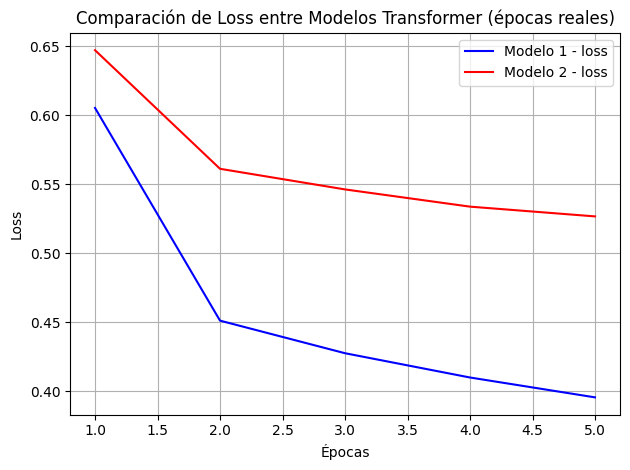

In [ ]:
epochs_1 = range(1, len(loss_1) + 1)
epochs_2 = range(1, len(loss_2) + 1)

plt.plot(epochs_1, loss_1, 'b-', label='Modelo 1 - loss')
plt.plot(epochs_2, loss_2, 'r-', label='Modelo 2 - loss')

plt.title('Comparación de Loss entre Modelos Transformer (épocas reales)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Evaluación del Modelo

In [ ]:
for muestra_str in pred_2.items():

    referencia = muestra_str[1]["referencia"]   # debería ser lista de tokens
    prediccion = muestra_str[1]["prediccion"]    # también lista de tokens

    # corpus_bleu espera: referencias = lista de listas de referencias
    score = sentence_bleu(referencia, prediccion, weights=(0.25, 0.25, 0.25, 0.25),
                      smoothing_function=SmoothingFunction().method1)

    print(f"{muestra_str[0]} - BLEU score: {score:.4f}")

muestra 0 - BLEU score: 0.0008
muestra 1 - BLEU score: 0.0008
muestra 2 - BLEU score: 0.0007
muestra 3 - BLEU score: 0.0006
muestra 4 - BLEU score: 0.0007


## 5. Presentación de Resultados y Conclusiones

Los valores obtenidos por la metrica de Bleu son coherentes teniendo en cuenta el sobre entrenamiento que posee el modelo y que tiende a responder unicamente con un par de palabras sin importar la pregunta que se le formule. La evaluación de la metrica se hizo con 4 N_gramas, es decir, se evalua si el token es el mismo al de la referencia de respuesta y si esta ubicado en la misma ubicacion que deberia estar.

**¿Se aplico validación en el entrenamiento usando el set de datos de validación?**

No, debido a la estructura que posee el transformer en este estudio, donde el embedding y la mascara de padding la aplica el transformer como una capa mas de procesamiento interno de los inputs que se le ingresan, no se puede aplicar el mismo proceso de vectorización (transformar en tensores) ni las mascaras de padding ya que el flujo de los datos de validación no sigue el mismo flujo, se almacena en la funcion de perdida y es unicamente procesado por el decoder - encoder.

**¿Causas del sobreentrenamiento?**

Justamente, la ausencia de datos de validacion no le permiten al modelo que en sus epocas de entrenamiento se ajuste de mejor forma, si bien el procesamiento de los datos de validacion no ajusta directamente al modelo puede indicarle de que forma debe ajustar sus calculos para mejorar la acertividad de su respuesta generada y la esperada. Si bien se aplico capas de dropout con distinto porcentaje de apagado de neuronas, no fue suficiente para que el modelo generalice de forma correcta.


**¿RNN, LSTM o Transformer?**

Sin duda, la mejor opcion, seria el transformer. Este aplica los mismos conceptos que la RNN o LSTM ya que tambien posee redes neuronales feed forward dentro, donde puede incluir tambien capas de LSTM o Bidirectional. Ahora lo que hace al transformer mejor ante estas opciones es la capacidad de tener componentes extras que ayudan significativamente al procesamiento de los datos, el aprendizaje y la generación de respuestas del modelo.

**¿Mejor modelo?**

Los 2 modelos generados, si bien se busco que los mismos entreguen el mejor rendimiento posible, debido al enfoque interno que tiene la arquitectura no es posible mitigar el sobreentrenamiento, al menos no con el tiempo restante para el estudio. NO se recomienda ninguno de los 2 modelos transformer, mas bien, se recomienda descomponer su arquitectura para poder aplicar, de manera manual y controlada, el embedding, positional encoding y las mascaras de padding fuera del mismo. Con esto se puede tener un mejor control de todo el procesamiento de datos, buscando afinar cada detalle que pueda perturbar la precisión del modelo.